# General setting

In all of the following graphs we use the transition probabilites estimated from group 4 of John Rust's 1987 paper. We stylize the cost parameters to (10, 10), instead if (10, 2.27). The simulation exercises are always with 200 buses over 70000 periods. For the construction of the uncertainty sets we always use the mean number of observations 4292 / 388.

In [1]:
extract_zips()

# Worst case probabilities

Shift of worst case probabilities for varying $\omega$ in state 0.

In [2]:
df_probability_shift()

,0.00,0.50,0.95
0,0.028658,0.003282,0.001713
1,0.081081,0.016607,0.009872
2,0.279124,0.101544,0.068706
3,0.246039,0.157888,0.121481
4,0.181733,0.204304,0.178590
5,0.130242,0.254743,0.252753
6,0.046598,0.157485,0.177194
7,0.003728,0.021620,0.027560
8,0.000466,0.004606,0.006646
9,0.000699,0.011694,0.019081


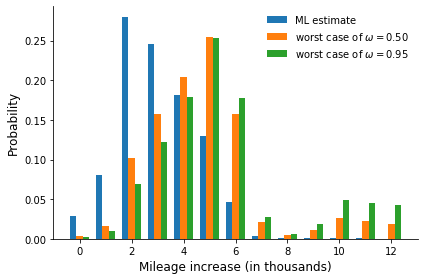

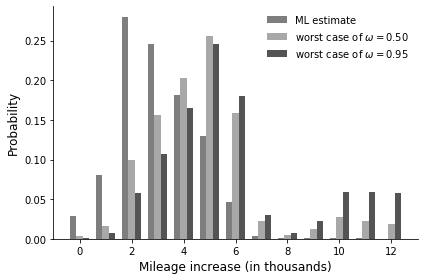

In [3]:
get_probability_shift()

# Replacement probability curve

The following figure shows the shift of the replacement probability curve. 

In [4]:
df_replacement_probabilties()

,0.00,0.50,0.95
0,0.000045,0.000045,0.000045
1,0.000056,0.000054,0.000054
2,0.000070,0.000065,0.000063
3,0.000086,0.000077,0.000074
4,0.000106,0.000091,0.000087
...,...,...,...
395,0.962941,0.956373,0.953595
396,0.963304,0.956792,0.954036
397,0.963661,0.957204,0.954472
398,0.964011,0.957612,0.954905


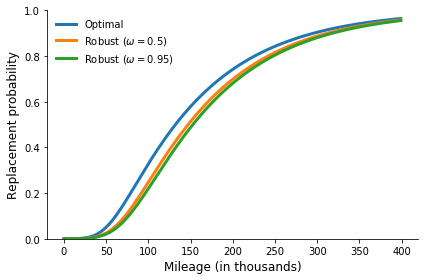

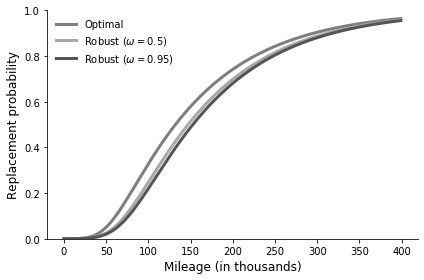

In [5]:
get_replacement_probabilities()

# Threshold plot

## Should we vary training sample and show effect? This is useful to discuss / explore the link between $\omega$ and the other paramters. This should be done in any case, the question is where.

The following figure shows the average state of replacement observed in simulated data. The means are rounded due to standard rounding rules. The underlying transition matrix governing the stochastic process of the milage increase is the ML estimate of Rust's paper.


In [6]:
df_thresholds()

,omega,threshold
0,0.00,67
1,0.01,73
2,0.02,73
3,0.03,73
4,0.04,74
...,...,...
95,0.95,80
96,0.96,81
97,0.97,81
98,0.98,81


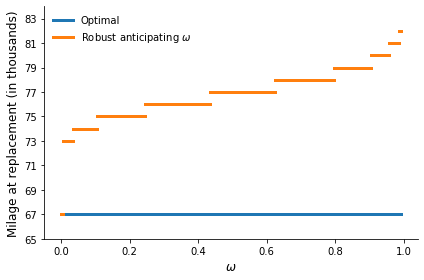

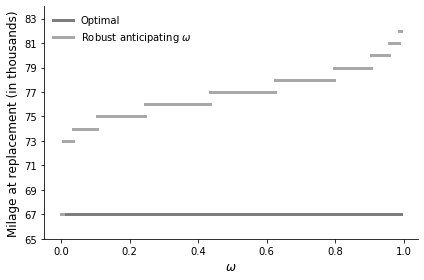

In [7]:
get_replacement_thresholds()

# Performance of 

The following figure shows the performance of the nominal strategy, when the worst case transition matrix of ω=0.99 is underlying. The two benchmarks are the expected value of an optimal strategy, when the underlying transition matrix is the ML estimate or the worst case transition matrix for omega=0.99.

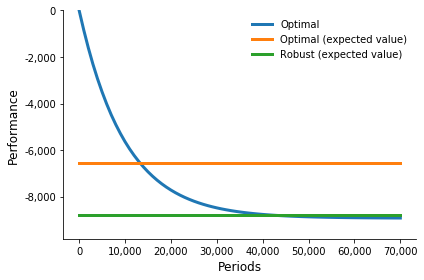

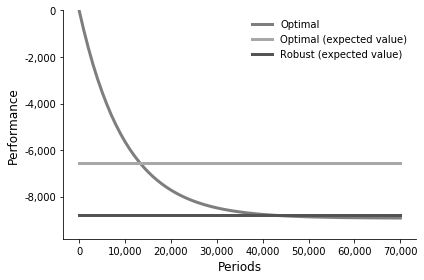

In [8]:
get_performance_decision_rules()

# Performance plot

The following figure show the simulated value at time zero of different strategies given the worst case transition matrix according to the $\omega$ on the x-axis.

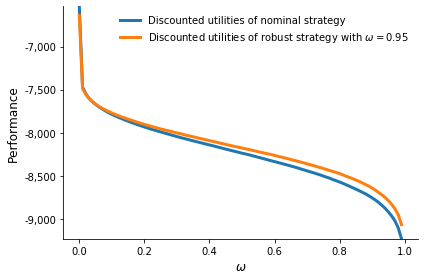

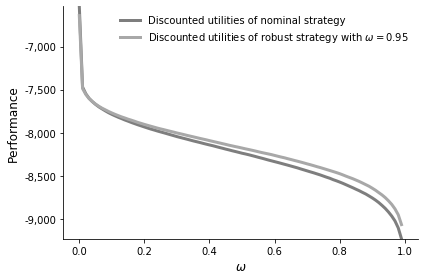

In [9]:
get_performance()

# Out of sample performance

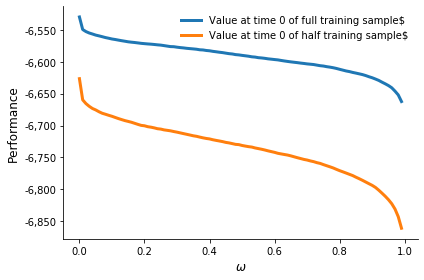

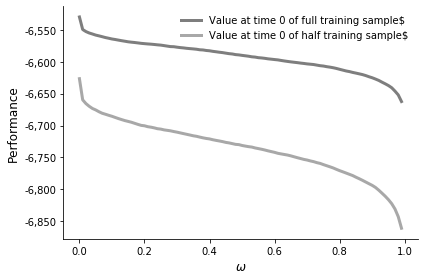

In [10]:
get_out_of_sample()